https://colab.research.google.com/drive/1VpvwkPrMoNZ1dCageJ0zk5Us555pL1C7?usp=sharing

In [123]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

# Data Pre-processing

In [124]:
from google.colab import files
uploaded = files.upload()

Saving Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv to Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001) (2).csv


In [125]:
# check if there any missing values in the dataset
def ViewingData(df):
  for column in df:
    print("{}\t\t\t\t{}".format(column, sum(df[column].isna())))

In [126]:
# import the csv file
df=pd.read_csv('Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv')
nullcols = df.columns[df.isnull().any()]
print(nullcols)

Index(['ArrestID', 'Perceived_Race', 'Age_group__at_arrest_',
       'Occurrence_Category', 'SearchReason_CauseInjury',
       'SearchReason_AssistEscape', 'SearchReason_PossessWeapons',
       'SearchReason_PossessEvidence', 'ItemsFound'],
      dtype='object')


In [127]:
df.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5


This table displays a sample of the first five rows of the Arrests and Strip Searches dataset.

In [128]:
# we can see the nan values for each attribute
ViewingData(df)

Arrest_Year				0
Arrest_Month				0
EventID				0
ArrestID				469
PersonID				0
Perceived_Race				4
Sex				0
Age_group__at_arrest_				24
Youth_at_arrest__under_18_years				0
ArrestLocDiv				0
StripSearch				0
Booked				0
Occurrence_Category				165
Actions_at_arrest___Concealed_i				0
Actions_at_arrest___Combative__				0
Actions_at_arrest___Resisted__d				0
Actions_at_arrest___Mental_inst				0
Actions_at_arrest___Assaulted_o				0
Actions_at_arrest___Cooperative				0
SearchReason_CauseInjury				57475
SearchReason_AssistEscape				57475
SearchReason_PossessWeapons				57475
SearchReason_PossessEvidence				57475
ItemsFound				57475
ObjectId				0


In [129]:
# remove all the nan values in ['ArrestID', 'Perceived_Race', 'Age_group__at_arrest_', 'Occurrence_Category']
# for 'searchreason', we fill nan value with 0 
df = df.dropna(subset = ['ArrestID', 'Perceived_Race', 'Age_group__at_arrest_', 'Occurrence_Category'])
df = df.fillna(0)
ViewingData(df)

Arrest_Year				0
Arrest_Month				0
EventID				0
ArrestID				0
PersonID				0
Perceived_Race				0
Sex				0
Age_group__at_arrest_				0
Youth_at_arrest__under_18_years				0
ArrestLocDiv				0
StripSearch				0
Booked				0
Occurrence_Category				0
Actions_at_arrest___Concealed_i				0
Actions_at_arrest___Combative__				0
Actions_at_arrest___Resisted__d				0
Actions_at_arrest___Mental_inst				0
Actions_at_arrest___Assaulted_o				0
Actions_at_arrest___Cooperative				0
SearchReason_CauseInjury				0
SearchReason_AssistEscape				0
SearchReason_PossessWeapons				0
SearchReason_PossessEvidence				0
ItemsFound				0
ObjectId				0


Data cleaning done.

In [130]:
# As we need the number of arrest for each quarter of the past two years, we need to assign a label to these eight quarters.
df["Quarter"] = np.where((df["Arrest_Year"] == 2020) & (df["Arrest_Month"] == "Jan-Mar"), 1, 
                               (np.where((df["Arrest_Year"] == 2020) & (df["Arrest_Month"] == "Apr-June"), 2, 
                                         (np.where((df["Arrest_Year"] == 2020) & (df["Arrest_Month"] == "July-Sept"), 3, 
                                                   (np.where((df["Arrest_Year"] == 2020) & (df["Arrest_Month"] == "Oct-Dec"), 4, 
                                                             (np.where((df["Arrest_Year"] == 2021) & (df["Arrest_Month"] == "Jan-Mar"), 5, 
                                                                       (np.where((df["Arrest_Year"] == 2021) & (df["Arrest_Month"] == "Apr-June"), 6, 
                                                                                 (np.where((df["Arrest_Year"] == 2021) & (df["Arrest_Month"] == "July-Sept"), 7, 
                                                                                           (np.where((df["Arrest_Year"] == 2021) & (df["Arrest_Month"] == "Oct-Dec"), 8, 0)))))))))))))))

In [131]:
# check 'Occurrence_Category'
df['Occurrence_Category'].unique()

array(['Assault & Other crimes against persons', 'Harassment/Threatening',
       'FTA/FTC/Compliance Check/Parollee', 'Assault', 'Robbery/Theft',
       'Sexual Related Crime', 'Mischief & Fraud', 'Warrant',
       'Police Category - Administrative',
       'FTA/FTC, Compliance Check & Parollee', 'Drug Related', 'Weapons',
       'Vehicle Related (inc. Impaired)', 'Other Offence',
       'Harassment & Threatening', 'Weapons & Homicide',
       'Robbery & Theft', 'Break and Enter', 'Mischief', 'Break & Enter',
       'Sexual Related Crimes & Crimes Against Children',
       'Crimes against Children', 'Police Category - Incident', 'Fraud',
       'LLA', 'Mental Health', 'Other Statute', 'Vehicle Related',
       'Other Statute & Other Incident Type', 'Impaired', 'Homicide'],
      dtype=object)

In [132]:
# classify the 'Occurrence_Category'
display_List = {
    "Assault & Other crimes against persons": "assault",
    "Assault": "assault",
    "Mischief & Fraud": "mischief",
    "Mischief & Fraud": "mischief",
    "Mischief": "mischief",
    "Fraud": "mischief",
    "FTA/FTC/Compliance Check/Parollee": "fta",
    "FTA/FTC, Compliance Check & Parollee": "fta",
    "Robbery/Theft": "robbery",
    "Robbery & Theft": "robbery",
    "Sexual Related Crime": "sexual and children",
    "Sexual Related Crimes & Crimes Against Children": "sexual and children",
    "Crimes against Children": "sexual and children",
    "Warrant": "warrant",
    "Police Category - Administrative": "police",
    "Police Category - Incident": "police",
    "Drug Related": "drug",
    "Weapons": "weapons and homicide",
    "Weapons & Homicide": "weapons and homicide",
    "Homicide": "weapons and homicide",
    "Vehicle Related (inc. Impaired)": "vehicle",
    "Vehicle Related": "vehicle",
    "Harassment & Threatening": "harassment",
    "Harassment/Threatening": "harassment",
    "Break and Enter": "break",
    "Break & Enter": "break",
    "Impaired": "impaired",
    "Mental Health": "other",
    "Other Offence": "other",
    "Other Statute": "other",
    "Other Statute & Other Incident Type": "other"
}

df['Occurrence_Category'] = df['Occurrence_Category'].replace(display_List)

df['Occurrence_Category'].unique()

array(['assault', 'harassment', 'fta', 'robbery', 'sexual and children',
       'mischief', 'warrant', 'police', 'drug', 'weapons and homicide',
       'vehicle', 'other', 'break', 'LLA', 'impaired'], dtype=object)

# Exploratory Data Analysis

In [133]:
# select columns and group data
sub = df[['Arrest_Year','Arrest_Month','Sex', 'StripSearch','ObjectId']]
sexsub = sub.groupby(['Arrest_Year','Arrest_Month','Sex']).agg({'ObjectId': 'count'})
sexsub = sexsub.reset_index()
sexsub

,Arrest_Year,Arrest_Month,Sex,ObjectId
0,2020,Apr-June,F,1172
1,2020,Apr-June,M,5615
2,2020,Apr-June,U,1
3,2020,Jan-Mar,F,2060
4,2020,Jan-Mar,M,7265
5,2020,July-Sept,F,1522
6,2020,July-Sept,M,6673
7,2020,July-Sept,U,1
8,2020,Oct-Dec,F,1309
9,2020,Oct-Dec,M,5899


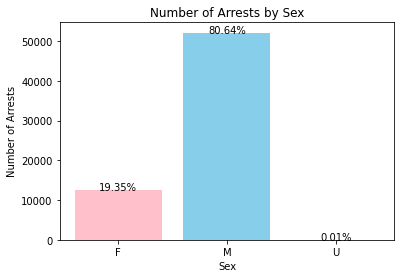

In [134]:
# Group the data by sex and sum the arrest counts
arrests_by_sex = sexsub.groupby(['Sex']).sum()['ObjectId']

# Calculate the total number of arrests
total_arrests = arrests_by_sex.sum()

# Calculate the percentage of arrests for each sex
percent_arrests_by_sex = 100 * arrests_by_sex / total_arrests

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(arrests_by_sex.index, arrests_by_sex.values, color=['pink', 'skyblue', 'gray'])
# Set the axis labels and title
ax.set_xlabel('Sex')
ax.set_ylabel('Number of Arrests')
ax.set_title('Number of Arrests by Sex')
# Show the percentages on the bars
for i, v in enumerate(arrests_by_sex.values):
    ax.text(i, v+1, str(round(percent_arrests_by_sex[i], 2)) + '%', ha='center')
plt.show()

As shown, 80.64% of the arrested individuals were male, 19.35% were female, and the unknown sex group accounted for only 0.01%.

In [135]:
# count arrests by sex
ucount = df['Sex'].value_counts()['U']
print('Unkown', ucount)
fcount = df['Sex'].value_counts()['F']
print('Female', fcount)
mcount = df['Sex'].value_counts()['M']
print('Male', mcount)

Unkown 9
Female 12500
Male 52106


In [136]:
import scipy.stats as stats
# Create separate subsets of different sex
M = sexsub[sexsub['Sex'] == 'M'][['ObjectId']]
F = sexsub[sexsub['Sex'] == 'F'][['ObjectId']]
U = sexsub[sexsub['Sex'] == 'U'][['ObjectId']]
print(M.shape[0])
print(F.shape[0])
print(U.shape[0])

8
8
5


In [137]:
# new DataFrame called sssub that groups arrest year & month, strip search, and objectid
sssub = sub.groupby(['Arrest_Year','Arrest_Month','StripSearch']).agg({'ObjectId': 'count'}).reset_index()
sssub

,Arrest_Year,Arrest_Month,StripSearch,ObjectId
0,2020,Apr-June,0,5115
1,2020,Apr-June,1,1673
2,2020,Jan-Mar,0,6802
3,2020,Jan-Mar,1,2523
4,2020,July-Sept,0,6064
5,2020,July-Sept,1,2132
6,2020,Oct-Dec,0,6871
7,2020,Oct-Dec,1,341
8,2021,Apr-June,0,8082
9,2021,Apr-June,1,154


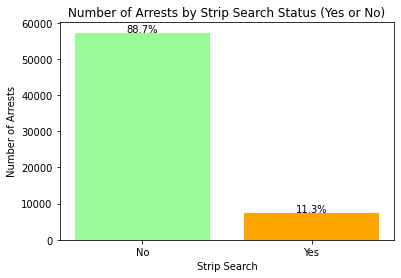

In [138]:
# Group the data by strip search status
substrip = df.groupby(['StripSearch']).agg({'ObjectId': 'count'})

# Calculate the percentage of arrests for each strip search status
substrip['Percentage'] = substrip['ObjectId'] / substrip['ObjectId'].sum() * 100

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(substrip.index, substrip['ObjectId'], color=['palegreen', 'orange'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Yes'])
# Set the axis labels and title
ax.set_xlabel('Strip Search')
ax.set_ylabel('Number of Arrests')
ax.set_title('Number of Arrests by Strip Search Status (Yes or No)')

# Add percentage labels to the chart
for i, v in enumerate(substrip['Percentage']):
    ax.text(i, substrip.iloc[i]['ObjectId'] + 200, f'{v:.1f}%', ha='center')

# Show the plot
plt.show()

As we can see from the bar chart above, 11.3% of the arrested individuals were subjected to the strip search. Based on the dataset, we found that 1,208 females and 6,123 males were subjected to a strip search after being arrested, while no people from unknown sex group were subjected to a strip search.

In [139]:
# Number of female were subjected to the strip search
female_stripsearch = df.loc[df['Sex'] == 'F'].groupby(['StripSearch']).count()['ObjectId']
print(female_stripsearch)

StripSearch
0    11292
1     1208
Name: ObjectId, dtype: int64


In [140]:
# Number of male were subjected to the strip search
male_stripsearch = df.loc[df['Sex'] == 'M'].groupby(['StripSearch']).count()['ObjectId']
print(male_stripsearch)

StripSearch
0    45983
1     6123
Name: ObjectId, dtype: int64


In [141]:
# Number of unknown sex group were subjected to the strip search
unknown_stripsearch = df.loc[df['Sex'] == 'U'].groupby(['StripSearch']).count()['ObjectId']
print(unknown_stripsearch)

StripSearch
0    9
Name: ObjectId, dtype: int64


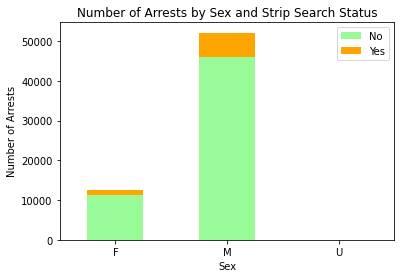

In [142]:
# Filter the dataframe to include only rows with male, female, or unknown sex
subsex = df[(df['Sex'] == 'M') | (df['Sex'] == 'F') | (df['Sex'] == 'U')]

# Group the data by sex and strip search status
substrip = subsex.groupby(['Sex', 'StripSearch']).agg({'ObjectId': 'count'})

# Reshape the data to create a stacked bar chart
substrip = substrip.unstack('StripSearch')

# Create a stacked bar chart with 2 colors
colors = ['palegreen', 'orange']
substrip.plot(kind='bar', stacked=True, color=colors)

# Set the axis labels and title
plt.xlabel('Sex')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests by Sex and Strip Search Status')

# Set the legend labels
leg_labels = ['No', 'Yes']
plt.legend(leg_labels, loc='upper right')

# Set the y-axis label orientation to horizontal
plt.xticks(rotation=0)

# Show the plot
plt.show()

The chart provides an overview of the number of arrests based on the sex and strip search status 

In [143]:
# display the selected columns
racesub=df[['Arrest_Year','Arrest_Month','ObjectId','Perceived_Race','StripSearch','Actions_at_arrest___Combative__','Actions_at_arrest___Cooperative']].dropna()
racesub

,Arrest_Year,Arrest_Month,ObjectId,Perceived_Race,StripSearch,Actions_at_arrest___Combative__,Actions_at_arrest___Cooperative
0,2020,July-Sept,1,White,0,0,1
1,2020,July-Sept,2,White,0,0,0
2,2020,Oct-Dec,3,Unknown or Legacy,0,0,0
3,2021,Jan-Mar,4,Black,0,0,0
4,2021,Jan-Mar,5,South Asian,0,0,0
...,...,...,...,...,...,...,...
65271,2021,Oct-Dec,65272,Indigenous,0,0,0
65272,2021,Oct-Dec,65273,South Asian,0,0,0
65273,2021,Oct-Dec,65274,White,0,0,0
65274,2021,Oct-Dec,65275,Unknown or Legacy,0,0,1


In [144]:
print(racesub['Perceived_Race'].unique())


['White' 'Unknown or Legacy' 'Black' 'South Asian' 'Indigenous'
 'Middle-Eastern' 'Latino' 'East/Southeast Asian']


In [145]:
racec = racesub.groupby(['Arrest_Year','Arrest_Month','Actions_at_arrest___Cooperative','Perceived_Race']).agg({'ObjectId': 'count'}).reset_index()

race_to_number = {
    'White': 1,
    'Unknown or Legacy': 2,
    'Black': 3,
    'South Asian': 4,
    'Indigenous': 5,
    'Middle-Eastern': 6,
    'Latino': 7,
    'East/Southeast Asian': 8
}

# Map race names to numbers
racec['Perceived_Race'] = racec['Perceived_Race'].map(race_to_number)
racec

,Arrest_Year,Arrest_Month,Actions_at_arrest___Cooperative,Perceived_Race,ObjectId
0,2020,Apr-June,0,3,1063
1,2020,Apr-June,0,8,197
2,2020,Apr-June,0,5,128
3,2020,Apr-June,0,7,73
4,2020,Apr-June,0,6,184
...,...,...,...,...,...
123,2021,Oct-Dec,1,7,138
124,2021,Oct-Dec,1,6,214
125,2021,Oct-Dec,1,4,229
126,2021,Oct-Dec,1,2,252


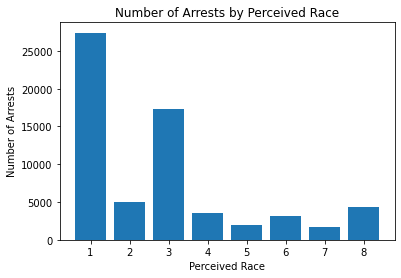

In [146]:
# group arrests people by perceived race
racetotal = racec.groupby('Perceived_Race')['ObjectId'].sum().reset_index()
fig, ax = plt.subplots()

ax.bar(racetotal['Perceived_Race'], racetotal['ObjectId'])
ax.set_xlabel('Perceived Race')
ax.set_ylabel('Number of Arrests')
ax.set_title('Number of Arrests by Perceived Race')
plt.show()

Based on the chart, it is evident that White and Black are the racial groups with the highest number of arrests, while Latino are arrested the least. 

In [147]:
# group arrests people by perceived race
races_people = df.Perceived_Race.value_counts().index.tolist()
race_number = df.Perceived_Race.value_counts()
print(race_number)

White                   27407
Black                   17352
Unknown or Legacy        5002
East/Southeast Asian     4388
South Asian              3594
Middle-Eastern           3213
Indigenous               1907
Latino                   1752
Name: Perceived_Race, dtype: int64


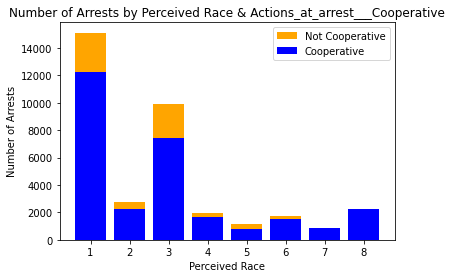

In [148]:
# group arrests people by perceived race
agg_df = racec.groupby(['Perceived_Race', 'Actions_at_arrest___Cooperative']).sum()['ObjectId'].unstack().reset_index()

# plot the bar chart
fig, ax = plt.subplots()
ax.bar(agg_df['Perceived_Race'], agg_df[0], color='orange', label='Not Cooperative')
ax.bar(agg_df['Perceived_Race'], agg_df[1], color='blue', label='Cooperative')
ax.set_xlabel('Perceived Race')
ax.set_ylabel('Number of Arrests')
ax.set_title('Number of Arrests by Perceived Race & Actions_at_arrest___Cooperative')
ax.legend()
plt.show()

As shown, the plot displays the sum of arrests grouped by perceived race and denotes whether they cooperate or not respectively.

In [149]:
# group cooperative or not ordered for arrested people by perceived race
race_coop = df.groupby('Perceived_Race').agg({'Actions_at_arrest___Cooperative': 'sum', 'ObjectId': 'count'})
race_coop_percent = (race_coop['Actions_at_arrest___Cooperative'] / race_coop['ObjectId']) * 100

# create a table to display the results
race_coop_table = pd.concat([race_coop['ObjectId'], race_coop['Actions_at_arrest___Cooperative'], race_coop_percent], axis=1, sort=False)
race_coop_table.columns = ['Total Arrests', 'Actions_at_arrest___Cooperative', 'Actions_at_arrest___Cooperative %']
race_coop_table.index.name = 'Perceived Race'
race_coop_table = race_coop_table.round(2)

race_coop_table

,Total Arrests,Actions_at_arrest___Cooperative,Actions_at_arrest___Cooperative %
Perceived Race,,,
Black,17352,7453,42.95
East/Southeast Asian,4388,2267,51.66
Indigenous,1907,758,39.75
Latino,1752,892,50.91
Middle-Eastern,3213,1509,46.97
South Asian,3594,1662,46.24
Unknown or Legacy,5002,2214,44.26
White,27407,12283,44.82


We found that East/Southeast Asian has the highest cooperation rate (51.66%) while Black people have the lowest cooperation rate (42.95%).


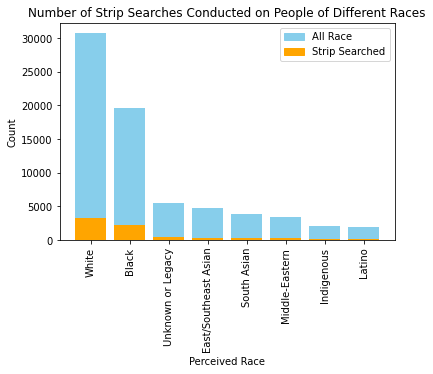

In [150]:
# group strip searches ordered for arrested people by perceived race
colors_race = {"All Race": "skyblue", "Strip Searched": "orange"}
labels_race = list(colors_race.keys())
handles_race = [plt.Rectangle((0, 0), 1, 1, color = colors_race[label]) for label in labels_race]

plt.bar(races_people, race_number, bottom = df.groupby(["Perceived_Race"])["StripSearch"].sum().sort_values(ascending = False), color = "skyblue")
plt.bar(races_people, df.groupby(["Perceived_Race"])["StripSearch"].sum().sort_values(ascending = False), color = "orange")
plt.xticks(rotation = 90)
plt.title("Number of Strip Searches Conducted on People of Different Races")
plt.ylabel("Count")
plt.xlabel("Perceived Race")
plt.legend(handles_race, labels_race)

In [151]:
# group strip searches ordered for arrested people by perceived race
race_stripsearch = df.groupby('Perceived_Race').agg({'StripSearch': 'sum', 'ObjectId': 'count'})
race_stripsearch_percent = (race_stripsearch['StripSearch'] / race_stripsearch['ObjectId']) * 100

# create a table to display the results
race_stripsearch_table = pd.concat([race_stripsearch['ObjectId'], race_stripsearch['StripSearch'], race_stripsearch_percent], axis=1, sort=False)
race_stripsearch_table.columns = ['Total Arrests', 'Strip Searched', 'Strip Searched %']
race_stripsearch_table.index.name = 'Perceived Race'
race_stripsearch_table = race_stripsearch_table.round(2)

race_stripsearch_table

,Total Arrests,Strip Searched,Strip Searched %
Perceived Race,,,
Black,17352,2299,13.25
East/Southeast Asian,4388,327,7.45
Indigenous,1907,287,15.05
Latino,1752,125,7.13
Middle-Eastern,3213,214,6.66
South Asian,3594,248,6.90
Unknown or Legacy,5002,493,9.86
White,27407,3338,12.18


It is obvious that Indigenous people have the highest strip search rate at 15.05%, followed by Black people at 13.25% and White people at 12.18%.

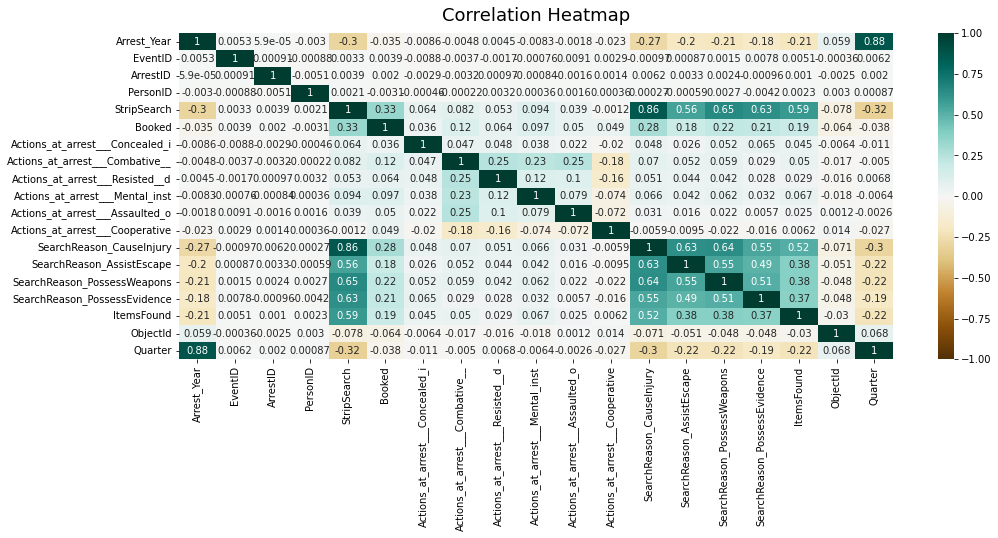

In [152]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

The heatmap indicated a strong correlation between strip searches and the reason for the search, particularly when the reason was to cause injury. 

# T-test


## T-test #1: Number of Arrests Male vs Female

H0 (Null Hypothesis): The mean number of arrests among sex groups is equal.

Ha (Alternative Hypothesis): The mean number of arrests among sex groups is not equal.

In [153]:
# check normality
stat, p = stats.shapiro(M)
print(p)
stat, p = stats.shapiro(F)
print(p)
#satisfied normality

0.44916629791259766
0.3535520136356354


In [154]:
# check equal variance
M = M.values.flatten()
F = F.values.flatten()
stat, p = stats.levene(M,F)
# equal variance
print(p)

0.23324344778964115


In [155]:
# Mean and STD for male and female
print("Male - mean: {:.2f}, std: {:.2f}".format(np.mean(M), np.std(M)))
print("Female - mean: {:.2f}, std: {:.2f}".format(np.mean(F), np.std(F)))

Male - mean: 6513.25, std: 490.29
Female - mean: 1562.50, std: 244.09


In [156]:
# t-test Female vs Male of arrested
t_statistic, p_value = stats.ttest_ind(M, F)
print(t_statistic,p_value)

23.915951554182907 9.407420494715217e-13


The P-value of the T-test evidenced the means of arrests between sex is signficantly different. We have enough evidence to reject the null hypothesis that means of arrest between sex are not equal.


## T-test #2: Comparing Mean Arrests of Cooperative Arrested People across Different Race Groups

H0 (Null Hypothesis): The mean of cooperative arrests is equal.

Ha (Alternative Hypothesis): The mean of cooperative arrests is not equal.

In [157]:
# create separate subsets of different race
ncoop = racec[racec['Actions_at_arrest___Cooperative'] == 1]
groupednc = ncoop.groupby(['Arrest_Year', 'Arrest_Month', 'Perceived_Race','Actions_at_arrest___Cooperative']).agg({'ObjectId': 'sum'}).reset_index()
groupednc


,Arrest_Year,Arrest_Month,Perceived_Race,Actions_at_arrest___Cooperative,ObjectId
0,2020,Apr-June,1,1,1395
1,2020,Apr-June,2,1,242
2,2020,Apr-June,3,1,740
3,2020,Apr-June,4,1,170
4,2020,Apr-June,5,1,68
...,...,...,...,...,...
59,2021,Oct-Dec,4,1,229
60,2021,Oct-Dec,5,1,87
61,2021,Oct-Dec,6,1,214
62,2021,Oct-Dec,7,1,138


In [158]:
# create a dictionary with race as keys and number of cases as values
race_object_dict = {i: [] for i in range(1, 9)}

# Iterate through each row and append the object ID to the corresponding list in the dictionary
for index, row in groupednc.iterrows():
    race = row['Perceived_Race']
    obj_id = row['ObjectId']
    race_object_dict[race].append(obj_id)
race_object_dict

{1: [1395, 1921, 1555, 1357, 1519, 1500, 1522, 1514],
 2: [242, 442, 263, 199, 276, 249, 291, 252],
 3: [740, 1168, 1003, 831, 914, 988, 885, 924],
 4: [170, 242, 224, 204, 205, 192, 196, 229],
 5: [68, 115, 103, 100, 82, 116, 87, 87],
 6: [155, 188, 188, 174, 199, 173, 218, 214],
 7: [97, 91, 112, 100, 112, 103, 139, 138],
 8: [226, 312, 291, 261, 263, 291, 278, 345]}

In [159]:
# use a loop to check normality of all races
for race in range(1, 9):
  # we don't care about the test statistic
    _, p_value = stats.shapiro(race_object_dict[race])
    if p_value > 0.05:
        print(f"Perceived Race {race} follows a normal distribution (p-value: {p_value})")
    else:
        print(f"Perceived Race {race} doesn't follow a normal distribution (p-value: {p_value})")

Perceived Race 1 doesn't follow a normal distribution (p-value: 0.014748751185834408)
Perceived Race 2 doesn't follow a normal distribution (p-value: 0.01561455987393856)
Perceived Race 3 follows a normal distribution (p-value: 0.9032807350158691)
Perceived Race 4 follows a normal distribution (p-value: 0.9320558309555054)
Perceived Race 5 follows a normal distribution (p-value: 0.6737602353096008)
Perceived Race 6 follows a normal distribution (p-value: 0.8120182156562805)
Perceived Race 7 follows a normal distribution (p-value: 0.14385639131069183)
Perceived Race 8 follows a normal distribution (p-value: 0.964289128780365)


In [160]:
# loop to use t-test to check the means of arrested with cooperative or not between races with the same sample size
for i in range(1, 8):
    for j in range(i+1, 9):
        if len(race_object_dict[i]) == len(race_object_dict[j]):
            _, p_value = stats.ttest_ind(race_object_dict[i], race_object_dict[j])
            if p_value > 0.05:
                print(f"Perceived Race {i} and {j}s' means are not significantly different (p-value: {p_value})")
            else:
                print(f"Perceived Race {i} and {j}s' means are significantly different (p-value: {p_value})")


Perceived Race 1 and 2s' means are significantly different (p-value: 1.7893882111715004e-11)
Perceived Race 1 and 3s' means are significantly different (p-value: 1.3045942557294891e-06)
Perceived Race 1 and 4s' means are significantly different (p-value: 3.2039290914641213e-12)
Perceived Race 1 and 5s' means are significantly different (p-value: 9.902788533585298e-13)
Perceived Race 1 and 6s' means are significantly different (p-value: 2.5916528805598022e-12)
Perceived Race 1 and 7s' means are significantly different (p-value: 1.1752976368404241e-12)
Perceived Race 1 and 8s' means are significantly different (p-value: 8.437135158673093e-12)
Perceived Race 2 and 3s' means are significantly different (p-value: 4.6956635945973466e-09)
Perceived Race 2 and 4s' means are significantly different (p-value: 0.02181337341150806)
Perceived Race 2 and 5s' means are significantly different (p-value: 6.655638312561267e-06)
Perceived Race 2 and 6s' means are significantly different (p-value: 0.00509

Among all races, only white and unknown races fail normality. A loop was applied to carry out T-Tests between the perceived races with equal sample sizes. Note that there are not enough evidence to prove the mean of cooperative arrests is significantly different between unknown races and East/Southeast Asian, South Asian and Middle Eastern, Indigenous and Latino. 

## T-test #3: Comparison of Drug-related Arrests’ Mean between Two Age Groups: 18-24 vs. 45-54

H0 (Null Hypothesis): The mean number of drug-related arrests per quarter for the two age groups (18-24 and 45-54 years old) is equal.

Ha (Alternative Hypothesis): The mean number of drug-related arrests per quarter for the two age groups (18-24 and 45-54 years old) is not equal.


Text(0.5, 0, 'Quarter, Year')

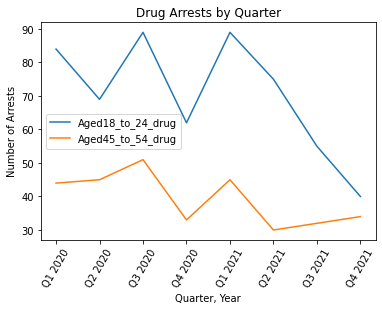

In [161]:
# Extract the quantity of drug-related arrests for the two age groups
Aged18_to_24_drug = df[(df['Occurrence_Category'] == 'drug') & (df['Age_group__at_arrest_'] == "Aged 18 to 24 years")]
Aged45_to_54_drug = df[(df['Occurrence_Category'] == 'drug') & (df['Age_group__at_arrest_'] == "Aged 45 to 54 years")]
Aged18_to_24_drug_Num = Aged18_to_24_drug.groupby(["Quarter"])["Occurrence_Category"].value_counts()
Aged45_to_54_drug_Num = Aged45_to_54_drug.groupby(["Quarter"])["Occurrence_Category"].value_counts()
Aged18_to_24_drug_Num.sort_index(ascending = True).plot(label='Aged18_to_24_drug')
Aged45_to_54_drug_Num.sort_index(ascending = True).plot(label='Aged45_to_54_drug')
plt.legend()

# add x-axis & y-axis
axes = plt.gca()
axes.set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7])
axes.set_xticklabels(["Q1 2020", "Q2 2020", "Q3 2020", "Q4 2020", "Q1 2021", "Q2 2021", "Q3 2021", "Q4 2021"])
plt.xticks(rotation = 60)
plt.title("Drug Arrests by Quarter")
plt.ylabel("Number of Arrests")
plt.xlabel("Quarter, Year")

As we can see from the above chart, the number of drug-related arrests is higher in the 18-24 age group than in the 45-54 age group.

In [162]:
# Mean and STD of two age groups
print("18-24 - mean: {:.2f}, std: {:.2f}".format(np.mean(Aged18_to_24_drug_Num), np.std(Aged18_to_24_drug_Num)))
print("45-54 - mean: {:.2f}, std: {:.2f}".format(np.mean(Aged45_to_54_drug_Num), np.std(Aged45_to_54_drug_Num)))

18-24 - mean: 70.38, std: 16.32
45-54 - mean: 39.25, std: 7.34


In [163]:
# check equal variance
stats.levene(Aged18_to_24_drug_Num, Aged45_to_54_drug_Num)

LeveneResult(statistic=4.054183419490714, pvalue=0.06369915689802944)

In [164]:
# t-test #3
stats.ttest_ind(Aged18_to_24_drug_Num, Aged45_to_54_drug_Num)
# The results indicate that there is a significant difference in the average number of drug-related arrests per quarter between the two age groups, 18-24 years and 45-54 years old. 
# From the graph, it can be seen that young people are more likely to be arrested for drug-related offenses on average than middle-aged individuals.

Ttest_indResult(statistic=4.600418077897046, pvalue=0.00041213578600516004)

Our results indicate the P-value is 0.000412, which is less than 0.05. Therefore, we can reject the null hypothesis. There is a significant difference in the mean number of drug-related arrests per quarter between the two age groups: 18-24 and 45-54 years old. 

## T-test #4: Comparison of Mean of Arrests in Different Arrest Location between The Two Age Groups: 18-24 vs. 45-54


H0 (Null Hypothesis): The mean number of arrests in different arrest location for the two age groups (18-24 and 45-54 years old) is equal.

Ha (Alternative Hypothesis):  The mean number of arrests in different arrest location for the two age groups (18-24 and 45-54 years old) is not equal.


young_arrest
[310, 175, 254, 304, 147, 237, 184, 187, 170, 209, 119, 150, 135, 135, 93, 80, 153]
old_arrest
[122, 120, 82, 79, 53, 91, 66, 87, 85, 92, 74, 77, 62, 87, 52, 52, 41]


Text(0.5, 0, 'Area Number')

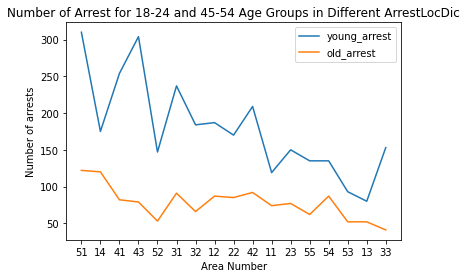

In [165]:
# initialize empty lists to store the number of arrests for young and old age groups in each location
young_arrest = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
old_arrest = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
my_data = pd.read_csv("Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")

# loop through the data to count the number of arrests in each location for each age group
num = 0
for i in range(len(my_data)):
    
    if pd.isnull(my_data["Sex"][i]) or pd.isnull(my_data["Age_group__at_arrest_"][i]) or pd.isnull(my_data["ArrestLocDiv"][i]):
        continue
    # assign a number to each location for indexing the lists
    if my_data["ArrestLocDiv"][i] == '51':
        num = 0
    elif my_data["ArrestLocDiv"][i] == '14':
        num = 1
    elif my_data["ArrestLocDiv"][i] == '41':
        num = 2
    elif my_data["ArrestLocDiv"][i] == '43':
        num = 3
    elif my_data["ArrestLocDiv"][i] == '52':
        num = 4
    elif my_data["ArrestLocDiv"][i] == '31':
        num = 5
    elif my_data["ArrestLocDiv"][i] == '32':
        num = 6
    elif my_data["ArrestLocDiv"][i] == '12':
        num = 7
    elif my_data["ArrestLocDiv"][i] == '22':
        num = 8
    elif my_data["ArrestLocDiv"][i] == '42':
        num = 9
    elif my_data["ArrestLocDiv"][i] == '11':
        num = 10
    elif my_data["ArrestLocDiv"][i] == '23':
        num = 11
    elif my_data["ArrestLocDiv"][i] == '55':
        num = 12
    elif my_data["ArrestLocDiv"][i] == '54':
        num = 13
    elif my_data["ArrestLocDiv"][i] == '53':
        num = 14
    elif my_data["ArrestLocDiv"][i] == '13':
        num = 15
    elif my_data["ArrestLocDiv"][i] == '33':
        num = 16 
    # increment the counter for each age group in each location
    if my_data["Age_group__at_arrest_"][i].startswith("Aged 17"):
        young_arrest[num] += 1
    elif my_data["Age_group__at_arrest_"][i].startswith("Aged 65"):
        old_arrest[num] += 1

print("young_arrest")
print(young_arrest)
print("old_arrest")
print(old_arrest)

plt.plot(young_arrest, label="young_arrest")
plt.plot(old_arrest, label="old_arrest")
plt.legend()

# add x-axis and y-axis
axes = plt.gca()
axes.set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
axes.set_xticklabels(["51", "14", "41", "43", "52", "31", "32", "12", "22", "42", "11", "23", "55", "54", "53", "13", "33"])
plt.title("Number of Arrest for 18-24 and 45-54 Age Groups in Different ArrestLocDic")  
plt.ylabel("Number of arrests")
plt.xlabel("Area Number")

The line chart above clearly shows that the number of arrests in 18-24 age group is higher than in the 45-54 age group across all locations.

In [166]:
# Mean and STD of two age groups in different locations
print("18-24&Locations - mean: {:.2f}, std: {:.2f}".format(np.mean(young_arrest), np.std(young_arrest)))
print("45-54&Locations - mean: {:.2f}, std: {:.2f}".format(np.mean(old_arrest), np.std(old_arrest)))

18-24&Locations - mean: 178.94, std: 64.20
45-54&Locations - mean: 77.76, std: 21.77


In [167]:
# check equal variance
stats.levene(young_arrest, old_arrest) 

LeveneResult(statistic=9.105886038370896, pvalue=0.004966249297639591)

In [168]:
# t-test #4
stats.ttest_ind(young_arrest, old_arrest)
# Number of arrest in 18-24 age group is higher than that of 45-54 age group in different ArrestLocDic

Ttest_indResult(statistic=5.96988799200853, pvalue=1.1842984727517885e-06)

As the p-value is 1.18e-6, which is less than 0.05. Therefore, we can reject the null hypothesis. This indicates that there is a significant difference in the number of arrests in different locations differ between two age groups. 

## T-test #5: Comparison of Mean of Arrests in Location 41 and 43


H0 (Null Hypothesis): The mean number of arrests in both locations is equal.

Ha (Alternative Hypothesis): The mean number of arrests in both locations is not equal.

Text(0.5, 0, 'Quarter, Year')

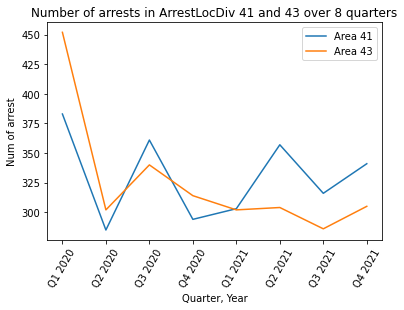

In [169]:
# extract the number of arrests in ArrestLocDic 41 and 43
arrestLoc_41 = df[df['ArrestLocDiv'] == '41']
arrestLoc_43 = df[df['ArrestLocDiv'] == '43']
# number of arrests in ArrestLocDic 41 and 43 for each quarter
arrestLoc_41_Num = arrestLoc_41.groupby(["Quarter"])["ArrestLocDiv"].value_counts()
arrestLoc_43_Num = arrestLoc_43.groupby(["Quarter"])["ArrestLocDiv"].value_counts()
arrestLoc_41_Num.sort_index(ascending = True).plot(label='Area 41')
arrestLoc_43_Num.sort_index(ascending = True).plot(label='Area 43')
plt.legend()

axes = plt.gca()
axes.set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7])
axes.set_xticklabels(["Q1 2020", "Q2 2020", "Q3 2020", "Q4 2020", "Q1 2021", "Q2 2021", "Q3 2021", "Q4 2021"])
plt.xticks(rotation = 60)
plt.title("Number of arrests in ArrestLocDiv 41 and 43 over 8 quarters") 
plt.ylabel("Num of arrest")
plt.xlabel("Quarter, Year")

As we can see from the chart, the number of arrests in location 41 started off lower than that in location 43, but in the last few quarters, the number of arrests in location 42 surpassed that in location 43. We need to conduct a t-test to determine whether there is a significant difference in the mean number of arrests between the location 41 and 43.

In [170]:
# Mean and STD of number of arrests in location 41 and 43
print("Location41 - mean: {:.2f}, std: {:.2f}".format(np.mean(arrestLoc_41_Num), np.std(arrestLoc_41_Num)))
print("Location43 - mean: {:.2f}, std: {:.2f}".format(np.mean(arrestLoc_43_Num), np.std(arrestLoc_43_Num)))

Location41 - mean: 330.00, std: 33.29
Location43 - mean: 325.62, std: 49.86


In [171]:
# check equal variance
stats.levene(arrestLoc_41_Num, arrestLoc_43_Num) 

LeveneResult(statistic=0.03354081357670087, pvalue=0.8573127865520122)

In [172]:
# t-test #5
stats.ttest_ind(arrestLoc_41_Num, arrestLoc_43_Num) 
# there is no significant difference between number of arrests in ArrestLocDic 41 and 43

Ttest_indResult(statistic=0.19306061042927, pvalue=0.849684268064064)

The results of the t-test indicated that the P-value is 0.85, which is much greater than the significance level of 0.05. Therefore,we cannot reject the null hypothesis and the findings indicate that there is no significant difference in the mean number of arrests between location 41 and 43. 


# One Way ANOVA #1: Perceived_Race & Number of Arrest 




H_0 (Null Hypothesis): The mean number of arrests across difference races is equal.

H_a (Alternative Hypothesis): The mean number of arrests across difference races is not equal.

In [173]:
from scipy.stats import f_oneway
# perform Welch's test to check the difference of mean
stat, p = f_oneway(*race_object_dict.values())

# print results
if p > 0.05:
    print("There is no significant difference in the means of the perceived races  (p-value: {:.4e})".format(p))
else:
    print("One or more means of the perceived races is significantly different than others(p-value: {:.4e})".format(p))


One or more means of the perceived races is significantly different than others(p-value: 1.4460e-42)


The one-way ANOVA test we performed indicated a significant difference in the mean number of arrests among different perceived races. Therefore, we can conclude that the number of arrests may be associated with the perceived race of the individuals. The findings are consistent with our literature review, which has shown that people from certain racial groups are more likely to be overrepresented in the criminal justice system. 


# One Way ANOVA #2: Comparison of the Mean Number of Arrests Among 6 locations (51,41,43,52,31,32)


H_0 (Null Hypothesis): The mean number of arrests across difference locations is equal.

H_a (Alternative Hypothesis): The mean number of arrests across difference locations is not equal.

Text(0.5, 0, 'Quarter, Year')

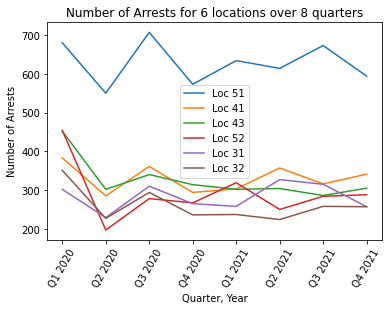

In [174]:
# based on T-test #5, we want to compare the mean number of arrests among 6 locations
arrestLoc_51 = df[df['ArrestLocDiv'] == '51']
arrestLoc_41 = df[df['ArrestLocDiv'] == '41']
arrestLoc_43 = df[df['ArrestLocDiv'] == '43']
arrestLoc_52 = df[df['ArrestLocDiv'] == '52']
arrestLoc_31 = df[df['ArrestLocDiv'] == '31']
arrestLoc_32 = df[df['ArrestLocDiv'] == '32']

# counts the number of arrests for each location over 8 quarters
arrestLoc_51_Num = arrestLoc_51.groupby(["Quarter"])["ArrestLocDiv"].value_counts()
arrestLoc_41_Num = arrestLoc_41.groupby(["Quarter"])["ArrestLocDiv"].value_counts()
arrestLoc_43_Num = arrestLoc_43.groupby(["Quarter"])["ArrestLocDiv"].value_counts()
arrestLoc_52_Num = arrestLoc_52.groupby(["Quarter"])["ArrestLocDiv"].value_counts()
arrestLoc_31_Num = arrestLoc_31.groupby(["Quarter"])["ArrestLocDiv"].value_counts()
arrestLoc_32_Num = arrestLoc_32.groupby(["Quarter"])["ArrestLocDiv"].value_counts()
arrestLoc_51_Num.sort_index(ascending = True).plot(label='Loc 51')
arrestLoc_41_Num.sort_index(ascending = True).plot(label='Loc 41')
arrestLoc_43_Num.sort_index(ascending = True).plot(label='Loc 43')
arrestLoc_52_Num.sort_index(ascending = True).plot(label='Loc 52')
arrestLoc_31_Num.sort_index(ascending = True).plot(label='Loc 31')
arrestLoc_32_Num.sort_index(ascending = True).plot(label='Loc 32')
plt.legend()

# plot the line chart to visualize the number of arrests
axes = plt.gca()
axes.set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7])
axes.set_xticklabels(["Q1 2020", "Q2 2020", "Q3 2020", "Q4 2020", "Q1 2021", "Q2 2021", "Q3 2021", "Q4 2021"])
plt.xticks(rotation = 60)
plt.title("Number of Arrests for 6 locations over 8 quarters")
plt.ylabel("Number of Arrests")
plt.xlabel("Quarter, Year")

As shown in the line chart above, Location 51 has a higher number of arrests compared to the other five locations.

In [175]:
statistic, pVal = stats.f_oneway(arrestLoc_51_Num, arrestLoc_41_Num, arrestLoc_43_Num, arrestLoc_52_Num, arrestLoc_31_Num, arrestLoc_32_Num)
print("statistic:%.2f "% statistic)
print("pVal:%e" % pVal)
# The P value is 1.13e-17, which is much smaller than 0.05.
# There is a significant difference in the mean number of arrests among 6 locations.

statistic:57.30 
pVal:1.130738e-17


In [176]:
df_loc = pd.DataFrame({
    "Location": np.repeat(['Area 51', 'Area 41', 'Area 43', 'Area 52', 'Area 31', 'Area 32'], repeats=8),
    "arrestArea": arrestLoc_51_Num.tolist() + arrestLoc_41_Num.tolist() + arrestLoc_43_Num.tolist() + arrestLoc_52_Num.tolist() + arrestLoc_31_Num.tolist() + arrestLoc_32_Num.tolist()
})
# print(df_loc)

tukey_loc = pairwise_tukeyhsd(endog=df_loc['arrestArea'], groups=df_loc['Location'], alpha=0.05)

print(tukey_loc)

# Location 51 exhibits a significant difference in the number of arrests compared to the other five locations.

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2 meandiff p-adj    lower     upper   reject
----------------------------------------------------------
Area 31 Area 32  -22.375    0.9  -98.9093   54.1593  False
Area 31 Area 41   47.125 0.4551  -29.4093  123.6593  False
Area 31 Area 43    42.75 0.5527  -33.7843  119.2843  False
Area 31 Area 51   345.25  0.001  268.7157  421.7843   True
Area 31 Area 52     9.25    0.9  -67.2843   85.7843  False
Area 32 Area 41     69.5 0.0942   -7.0343  146.0343  False
Area 32 Area 43   65.125 0.1354  -11.4093  141.6593  False
Area 32 Area 51  367.625  0.001  291.0907  444.1593   True
Area 32 Area 52   31.625 0.7948  -44.9093  108.1593  False
Area 41 Area 43   -4.375    0.9  -80.9093   72.1593  False
Area 41 Area 51  298.125  0.001  221.5907  374.6593   True
Area 41 Area 52  -37.875 0.6587 -114.4093   38.6593  False
Area 43 Area 51    302.5  0.001  225.9657  379.0343   True
Area 43 Area 52    -33.5  0.754 -110.0343   43.0343  Fal

Location 51 exhibits a significant difference in the number of arrests compared to the other five locations.

# Two Way ANOVA #*1*: Perceived_Race & Actions_at_arrest___Cooperative & Number of Arrest 

H_0 (Null Hypothesis): There is no significant interaction effect or main effect of perceived race, cooperation on number of arrests.

H_a (Alternative Hypothesis): There is a significant interaction effect or main effect of perceived race, cooperation on number of arrests.

In [177]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 2 way ANOVA model
model = ols('ObjectId ~ C(Perceived_Race) + C(Actions_at_arrest___Cooperative) + C(Perceived_Race):C(Actions_at_arrest___Cooperative)', data=racec).fit()

# generate the ANOVA table
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
C(Perceived_Race),3.778557e+07,7.0,763.741623,2.195836e-91
C(Actions_at_arrest___Cooperative),3.340509e+05,1.0,47.264077,3.708155e-10
C(Perceived_Race):C(Actions_at_arrest___Cooperative),5.828127e+05,7.0,11.780114,3.617279e-11
Residual,7.915886e+05,112.0,NaN,NaN


Based on the test results, perceived race, cooperative or not at arrests and their interaction effects are all statistically significant, as evidenced by their P-values being smaller than 0.05. Among them, the effect of perceived race seems to be the most significant, with a high F statistic, while the interaction effect was relatively small. To further investigate the effects, a Tukey HSD is carried out.

In [178]:
# tukey
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_race = pairwise_tukeyhsd(endog=racec['ObjectId'], groups=racec['Perceived_Race'], alpha=0.05)
tukey_strip = pairwise_tukeyhsd(endog=racec['ObjectId'], groups=racec['Actions_at_arrest___Cooperative'], alpha=0.05)
print("Tukey test for Perceived Race:")
print(tukey_race)
print()
print("Tukey test for Cooperation:")
print(tukey_strip)

Tukey test for Perceived Race:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
     1      2 -1400.3125  0.001 -1530.4567 -1270.1683   True
     1      3  -628.4375  0.001  -758.5817  -498.2933   True
     1      4 -1488.3125  0.001 -1618.4567 -1358.1683   True
     1      5   -1593.75  0.001 -1723.8942 -1463.6058   True
     1      6  -1512.125  0.001 -1642.2692 -1381.9808   True
     1      7 -1603.4375  0.001 -1733.5817 -1473.2933   True
     1      8 -1438.6875  0.001 -1568.8317 -1308.5433   True
     2      3    771.875  0.001   641.7308   902.0192   True
     2      4      -88.0 0.4325  -218.1442    42.1442  False
     2      5  -193.4375  0.001  -323.5817   -63.2933   True
     2      6  -111.8125 0.1485  -241.9567    18.3317  False
     2      7   -203.125  0.001  -333.2692   -72.9808   True
     2      8    -38.375    0.9  -168.5192    91.7692 

The result suggests that the comparison between strip searched or not was not significant, while all possible comparisons of means of perceived race were significant except for two groups. These findings suggest that there are significant differences in the mean values of the dependent variable among different groups based on their perceived race.

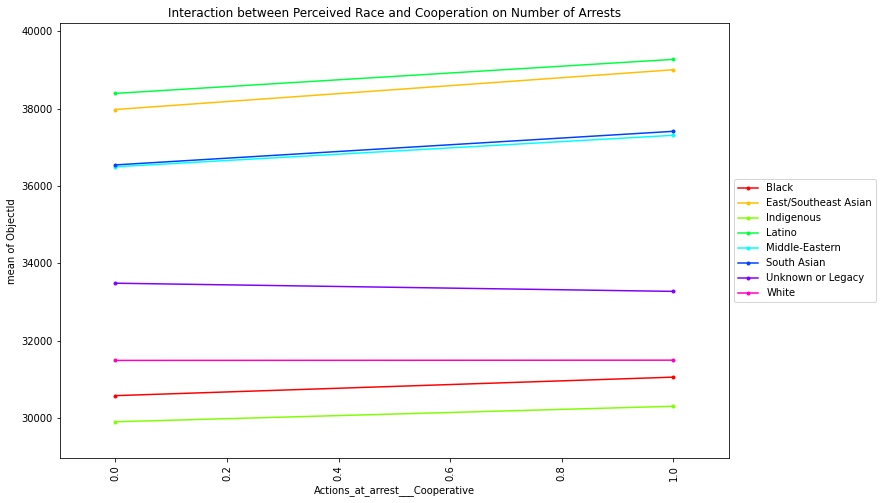

In [179]:
# Create the interaction plot
fig, ax = plt.subplots(figsize=(12, 8))
interaction_plot(x=df["Actions_at_arrest___Cooperative"], trace=df["Perceived_Race"], response=df["ObjectId"], ax=ax)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add title
ax.set_title("Interaction between Perceived Race and Cooperation on Number of Arrests")

# Move legend to the right
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Show the plot
plt.show()

The two-way ANOVA test we performed revealed that perceived race, cooperative or not during arrests and their interaction effects are all statistically significant in relation to the toal number of arrests, which is consistent to the interaction plot where the lines are not parallel. The lines trend in the same direction, indicating a possible positive interaction effect. To further investigate the effects, we conducted a Tukey HSD test, which suggests that there are significant differences in the number of arrests based on perceived race among most groups, while the level of cooperation during arrests did not differ significantly.

# Two Way ANOVA #*2*:Perceived_Race & Actions_at_arrest___Cooperative & Strip Search

H_0 (Null Hypothesis): There is no significant interaction effect or main effect of perceived race, cooperation on number of strip searches.

H_a (Alternative Hypothesis): There is a significant interaction effect or main effect of perceived race, cooperation on number of strip searches.


In [180]:
# Filter the dataframe by StripSearch == 1
ssracec = racesub[racesub['StripSearch'] == 1]
# Group the dataframe
ssracec = ssracec.groupby(['Arrest_Year','Arrest_Month','Actions_at_arrest___Cooperative','Perceived_Race']).agg({'ObjectId': 'count'}).reset_index()

# Create a dictionary to map race names to numbers
race_to_number = {
    'White': 1,
    'Unknown or Legacy': 2,
    'Black': 3,
    'South Asian': 4,
    'Indigenous': 5,
    'Middle-Eastern': 6,
    'Latino': 7,
    'East/Southeast Asian': 8
}

# Map race names to numbers
ssracec['Perceived_Race'] = ssracec['Perceived_Race'].map(race_to_number)
ssracec

,Arrest_Year,Arrest_Month,Actions_at_arrest___Cooperative,Perceived_Race,ObjectId
0,2020,Apr-June,0,3,298
1,2020,Apr-June,0,8,34
2,2020,Apr-June,0,5,48
3,2020,Apr-June,0,7,14
4,2020,Apr-June,0,6,29
...,...,...,...,...,...
116,2021,Oct-Dec,1,5,2
117,2021,Oct-Dec,1,6,3
118,2021,Oct-Dec,1,4,1
119,2021,Oct-Dec,1,2,3


In [181]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 2 way ANOVA model
model1 = ols('ObjectId ~ C(Perceived_Race) + C(Actions_at_arrest___Cooperative) + C(Perceived_Race):C(Actions_at_arrest___Cooperative)', data=ssracec).fit()


# generate the ANOVA table
sm.stats.anova_lm(model1, typ=2)

,sum_sq,df,F,PR(>F)
C(Perceived_Race),6.195917e+05,7.0,7.997475,9.171208e-08
C(Actions_at_arrest___Cooperative),4.830548e+03,1.0,0.436457,5.102842e-01
C(Perceived_Race):C(Actions_at_arrest___Cooperative),9.776079e+03,7.0,0.126186,9.962794e-01
Residual,1.162101e+06,105.0,NaN,NaN


The results of the two-way ANOVA with interaction shows that there is a significant effect of perceived race on the number of strip search, while cooperative or not and the interaction effect are not significant. This suggests that the level of the dependent variable differs significantly among different levels of perceived races.

In [182]:
# tukey
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Calculate the Tukey's HSD test for the perceived race and cooperative actions columns
tukey_race = pairwise_tukeyhsd(endog=ssracec['ObjectId'], groups=ssracec['Perceived_Race'], alpha=0.05)
tukey_strip = pairwise_tukeyhsd(endog=ssracec['ObjectId'], groups=ssracec['Actions_at_arrest___Cooperative'], alpha=0.05)

# Print the results of the Tukey's HSD test
print("Tukey test for Perceived Race:")
print(tukey_race)
print()
print("Tukey test for Strip Search:")
print(tukey_strip)

Tukey test for Perceived Race:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
     1      2 -177.8125  0.001 -289.2379 -66.3871   True
     1      3  -64.9375 0.6051 -176.3629  46.4879  False
     1      4 -190.9107  0.001  -306.247 -75.5745   True
     1      5  -188.125  0.001 -303.4612 -72.7888   True
     1      6 -194.3583  0.001 -307.6256 -81.0911   True
     1      7 -199.6964  0.001 -315.0327 -84.3602   True
     1      8 -188.1875  0.001 -299.6129 -76.7621   True
     2      3   112.875 0.0448    1.4496 224.3004   True
     2      4  -13.0982    0.9 -128.4345  102.238  False
     2      5  -10.3125    0.9 -125.6487 105.0237  False
     2      6  -16.5458    0.9 -129.8131  96.7214  False
     2      7  -21.8839    0.9 -137.2202  93.4523  False
     2      8   -10.375    0.9 -121.8004 101.0504  False
     3      4 -125.9732  0.022 -241.3095  -10.637   True


The test revealed that there were significant differences in the mean number of arrests for all pairs of races, except for groups 2 and 3. Specifically, the mean number of strip search for White was significantly lower than that of all other racial groups. The mean number of arrests for individuals in South Asian, Indigenous, Middle Eastern, Latino, East/Southeast Asian were also significantly lower than that of Unknown and Black. There was no significant difference in the mean number of strip search between Black and Unknown people.

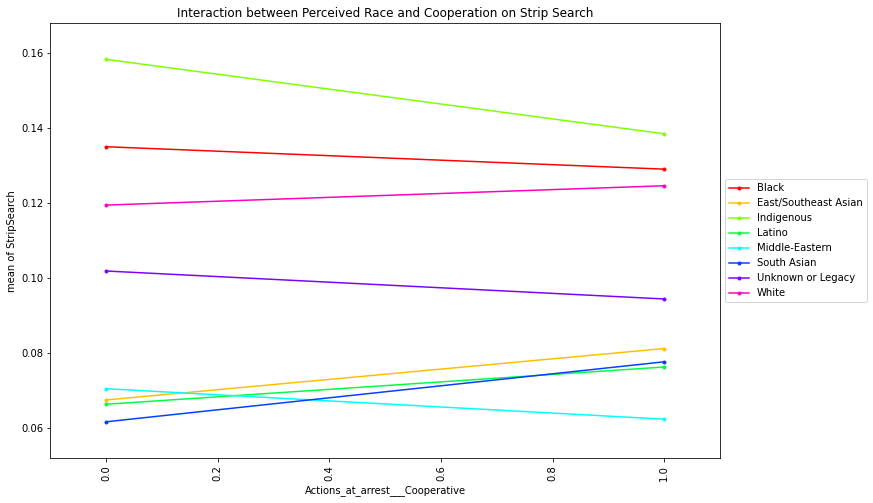

In [183]:
# Create the interaction plot
fig, ax = plt.subplots(figsize=(12, 8))
interaction_plot(x=df["Actions_at_arrest___Cooperative"], trace=df["Perceived_Race"], response=df["StripSearch"], ax=ax)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add title
ax.set_title("Interaction between Perceived Race and Cooperation on Strip Search")
# Move legend to the right
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Show the plot
plt.show()


The results indicate that there is no association between cooperation and strip searches. In addition, the finding suggest that the race of an individual may play a role in the number of strip searches made by the police, with certain racial groups being more likely to be sujected to strip searches than others. Note that the lines in the interaction plot are not parallel, however we found no significant maineffect of cooperation, this could due to random variation in the data or other unmeasured factor and small sample size.